# GPT-2 Adoption

Code from https://github.com/graykode/gpt-2-Pytorch

In [1]:
import copy
import torch
import math
import torch.nn as nn
from torch.nn.parameter import Parameter


In [2]:
import random
import numpy as np

# Reproducibility
seed = random.randint(0, 2147483647)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 
# GPTConfig - HuggingFace style

In [3]:
class GPT2Config(object):
    def __init__(
            self,
            vocab_size_or_config_json_file=50257,
            n_positions=1024,
            n_ctx=1024,
            n_embd=768,
            n_layer=12,
            n_head=12,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,
            pdrop=0.1,
    ):
        self.vocab_size = vocab_size_or_config_json_file
        self.n_ctx = n_ctx
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.pdrop = pdrop

#### 
# Wandb managing experiments

In [4]:
import wandb
wandb.init(project="gpt_music_lyrics", entity="tst008")
!wandb on

wandb: Currently logged in as: tst008 (use `wandb login --relogin` to force relogin)


W&B online, running your script from this directory will now sync to the cloud.


#### 
# Creating Model

Layer Norm: $y = \frac{x-E[x]}{\sqrt{Var[x] + \epsilon}} * \gamma + \beta$

- Where x is a mini-batch of input, with dimension `normalized_shape`.
- $\gamma$ and $\beta$ are $\textit{learnable}$ affine transform parameters

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

In [6]:
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = LayerNorm(embedding_dim)
layer_norm(embedding).shape

torch.Size([20, 5, 10])

- Input: $N, C, L$, Output: $N, C, L_o$

$out(N, C_j) =  bias(C_j) + \sum^{C_i - 1}_{k=1}w(C_j, k) * inp(N_i, k)$

In [7]:
class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        self.nx = nx
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = Parameter(w)
        self.bias = Parameter(torch.zeros(nf))

    def forward(self, x):
        assert self.nx == x.shape[-1], f"Shape mismatched, expected shape: {list(x.shape[:-1])+[self.nx]}, got shape: {list(x.shape)}"
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x

In [8]:
m = Conv1D(10, 50)
i = torch.randn(20, 16, 50)
m(i).shape

torch.Size([20, 16, 10])

Applies multi-head attention 

- Query: representation of current word used to score against other words
- Key: labels for all potentially relevant words in segment
- Value: Actual word representations. Relevancy of each word is added up to represent current word

Input size, output size??
https://jalammar.github.io/illustrated-gpt2/

In [9]:
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)
        self.attn_drop = nn.Dropout(config.pdrop, inplace=False)
        self.resid_drop = nn.Dropout(config.pdrop, inplace=False)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        try:
            b = self.bias[:, :, ns-nd:ns, :ns]
            w = w * b - 1e10 * (1 - b)
            w = nn.Softmax(dim=-1)(w)
        except:
            print(b.shape, w.shape)
            raise
        return w, torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, layer_past=None):
        # Begin by looking at the shape of all these
#         print(f"x:{x.shape}")
        x = self.c_attn(x)
#         print(f"(after c_attn) x:{x.shape}")
        query, key, value = x.split(self.split_size, dim=2)
#         print(f"query:{query.shape}, key:{key.shape}, value:{value.shape},")
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
#         print(f"(after split_heads()) query:{query.shape}, key:{key.shape}, value:{value.shape},")
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
#             print(f"(in if layer_past is not None) query:{query.shape}, key:{key.shape}, value:{value.shape},")
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
#         print(f"present:{present.shape}")
        w, a = self._attn(query, key, value)
#         print(f"(output of _attn) a:{a.shape}")
        a = self.merge_heads(a)
#         print(f"(output of merge_heads) a:{a.shape}")
        a = self.c_proj(a)
#         print(f"(output of c_proj) a:{a.shape}")
        a = self.resid_drop(a)
#         print(f"(output of resid_drop) a:{a.shape}")
        return a, present, w # Present key and values?

In [10]:
# TODO: Test Masked before softmax, 

In [11]:
w = torch.ones([1, 1, 1024, 1024]) #torch.Size([1, 12, 1760, 1760])
b = torch.ones([1, 12,])
nd, ns = w.size(-2), w.size(-1)
nd, ns

(1024, 1024)

Applies the Gaussian Error Linear Units function:
    
$y = x * \Phi(x)$

where $\Phi(x)$ is the Cumulative Distribution Function for Gaussian Distribution

... tho I'm not seeing that here

In [12]:
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [13]:
gelu(torch.randn(2))

tensor([0.0010, 0.6200])

Conv1D(n_state, n_embd) $\implies$ gelu $\implies$ Conv1D(n_embd, n_state)  

In [14]:
class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = gelu
        self.dropout = nn.Dropout(config.pdrop)

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        h2 = self.dropout(h2)
        return h2

In [15]:
import argparse
config = argparse.Namespace(
    n_embd = 15,
    pdrop = .1,
)
i = torch.randn(10, 3, 15)
mlp = MLP(30, config)
mlp(i).shape

torch.Size([10, 3, 15])

Returns: 
- $x + (LN(x) \implies ATTN(x)) + MLP(x)$
- `present` the cumulative keys and values?

In [16]:
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        a, present, _ = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present

In [17]:
# TODO: Test Block

Decoder-only Transformer GPT-2

In [18]:
class GPT2Model(nn.Module):
    def __init__(self, config):
        super(GPT2Model, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.vocab_size

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        
        self.drop = nn.Dropout(config.pdrop, inplace=False)
        
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, 
                              eps=config.layer_norm_epsilon)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, input_ids, 
                position_ids=None, 
                token_type_ids=None, 
                past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_ids.size(-1) + past_length, dtype=torch.long,
                                        device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_ids.size(-1))
        position_ids = position_ids.view(-1, position_ids.size(-1))

        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        presents = []
        for block, layer_past in zip(self.h, past):
            hidden_states, present = block(hidden_states, layer_past)
            presents.append(present)
        hidden_states = self.drop(hidden_states)
        hidden_states = self.ln_f(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)
        return hidden_states.view(*output_shape), presents

In [19]:
# TODO: Initial test

In [20]:
class GPT2LMHead(nn.Module):
    def __init__(self, model_embeddings_weights, config):
        super(GPT2LMHead, self).__init__()
        self.n_embd = config.n_embd
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        # Truncated Language modeling logits (we remove the last token)
        # h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(hidden_state)
        return lm_logits

In [21]:
class GPT2LMHeadModel(nn.Module):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__()
        self.transformer = GPT2Model(config)
        self.lm_head = GPT2LMHead(self.transformer.wte.weight, config)

    def set_tied(self):
        """ Make sure we are sharing the embeddings
        """
        self.lm_head.set_embeddings_weights(self.transformer.wte.weight)

    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        hidden_states, presents = self.transformer(input_ids, position_ids, token_type_ids, past)
        lm_logits = self.lm_head(hidden_states)
        if lm_labels is not None:
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = lm_labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
#             loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
#             loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            return loss, lm_logits, presents
        return lm_logits, presents

#### 
# Encoder

In [22]:
import os
import json
import regex as re
from os.path import expanduser
# from functools import lru_cache

# @lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class Encoder:
    def __init__(self, encoder, bpe_merges, errors='replace'):
        self.encoder = encoder
        self.decoder = {v:k for k,v in self.encoder.items()}
        self.errors = errors # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}
        self.special_tokens = []

        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        self.re_pattern = r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
        self.pat = re.compile(self.re_pattern)
        
    def add_special_token(self, s):
        if s in self.special_tokens:
            print(f"Token {s} already added")
        self.special_tokens.append(s)
        if s in self.encoder: 
            # Special token already known, but regex pattern cannot capture fully yet
            pass
        else:
            self.encoder[s] = len(self.encoder)+1
            self.decoder[len(self.encoder)+1] = s
        s = s.replace("|", r"\|")
        self.re_pattern = " " + s + "|" + self.re_pattern
        self.pat = re.compile(self.re_pattern)

    def bpe(self, token):
        # Also don't split on special tokens
        if token in self.special_tokens:
            return token
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors=self.errors)
        return text

def get_encoder():
    home = expanduser("~")
    with open(os.path.join(home, 'data/GPT2/encoder.json'), 'r') as f:
        encoder = json.load(f)
    with open(os.path.join(home, 'data/GPT2/vocab.bpe'), 'r', encoding="utf-8") as f:
        bpe_data = f.read()
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
    enc = Encoder(
        encoder=encoder,
        bpe_merges=bpe_merges,
    )
    enc.add_special_token("<|endoftext|>")
    enc.add_special_token("<|GOAL|>")
    enc.add_special_token("<|PROOFSTEP|>")
    print(enc.special_tokens)
    return enc

vocab_size_or_config_json_file=50257,
n_positions=1024,
n_ctx=1024,
n_embd=768,
n_layer=12,
n_head=12,
layer_norm_epsilon=1e-5,
initializer_range=0.02,

#### 
# Loading model

In [23]:
# Load Model
# enc = get_encoder()
config = GPT2Config()
model = GPT2LMHeadModel(config)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_drop): Dropout(p=0.1, inplace=False)
          (resid_drop): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_drop): Dropout(p=0.1, inplace=False)
          (resid_drop): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
   

In [24]:
state_dict = torch.load('gpt2-pytorch_model.bin', map_location='cpu' if not torch.cuda.is_available() else None)

old_keys = []
new_keys = []
for key in state_dict.keys():
    new_key = None
    if key.endswith(".g"):
        new_key = key[:-2] + ".weight"
    elif key.endswith(".b"):
        new_key = key[:-2] + ".bias"
    elif key.endswith(".w"):
        new_key = key[:-2] + ".weight"
    if new_key:
        old_keys.append(key)
        new_keys.append(new_key)
for old_key, new_key in zip(old_keys, new_keys):
    state_dict[new_key] = state_dict.pop(old_key)
# model.load_state_dict(state_dict)
missing_keys = []
unexpected_keys = []
error_msgs = []
# copy state_dict so _load_from_state_dict can modify it
metadata = getattr(state_dict, "_metadata", None)
state_dict = state_dict.copy()
if metadata is not None:
    state_dict._metadata = metadata

def load(module, prefix=""):
    local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
    module._load_from_state_dict(
        state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs
    )
    for name, child in module._modules.items():
        if child is not None:
            load(child, prefix + name + ".")

start_model = model
if hasattr(model, "transformer") and all(not s.startswith('transformer.') for s in state_dict.keys()):
    start_model = model.transformer
load(start_model, prefix="")

model.set_tied()
type(model) == GPT2LMHeadModel

True

#### 
# Sampling a sequence

In [25]:
import torch
import torch.nn.functional as F
from tqdm import trange

def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values, torch.ones_like(logits, dtype=logits.dtype) * -1e10, logits)

def sample_sequence(model, length, start_token=None, batch_size=None, context=None, temperature=1, top_k=0, device='cuda', sample=True):
    if start_token is None:
        assert context is not None, 'Specify exactly one of start_token and context!'
        context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
    else:
        assert context is None, 'Specify exactly one of start_token and context!'
        context = torch.full((batch_size, 1), start_token, device=device, dtype=torch.long)
    prev = context
    output = context
    past = None
    with torch.no_grad():
        for i in range(length):
#             print(prev.shape)
#             raise
            logits, past = model(prev, past=past)
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, k=top_k)
            log_probs = F.softmax(logits, dim=-1)
            if sample:
                prev = torch.multinomial(log_probs, num_samples=1)
            else:
                _, prev = torch.topk(log_probs, k=1, dim=-1)
            output = torch.cat((output, prev), dim=1)
    return output

# def sample_sequence(model, length, start_token=None, batch_size=None, context=None, temperature=1, top_k=0, device='cuda', sample=True):
#     if start_token is None:
#         assert context is not None, 'Specify exactly one of start_token and context!'
#         context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
#     else:
#         assert context is None, 'Specify exactly one of start_token and context!'
#         context = torch.full((batch_size, 1), start_token, device=device, dtype=torch.long)
#     prev = context
#     output = context
#     past = None
#     with torch.no_grad():
#         for i in range(length):
# #             print(prev.shape)
# #             raise
#             loss, logits, past = model(prev,
#                                  lm_labels=prev,
#                                  past=past)
#             print(loss)
#             logits = logits[:, -1, :] / temperature
#             logits = top_k_logits(logits, k=top_k)
#             log_probs = F.softmax(logits, dim=-1)
#             if sample:
#                 prev = torch.multinomial(log_probs, num_samples=1)
#             else:
#                 _, prev = torch.topk(log_probs, k=1, dim=-1)
#             output = torch.cat((output, prev), dim=1)
#     return output

#### 
# Try running

In [26]:
# TODO: Turn into notebook style

import os
import sys
import torch
import random
import argparse
import numpy as np

args = argparse.Namespace(
    text="It was a bright cold day in April.",
    quiet=False,
    nsamples=1,
    unconditional=False,
    batch_size=1,
    length=200,
    temperature=0.7,
    top_k=40,
)

if args.quiet is False:
    print(args)

if args.batch_size == -1:
    args.batch_size = 1
assert args.nsamples % args.batch_size == 0

# Load Model
enc = get_encoder()
model.to(device)
model.eval()

if args.length == -1:
    args.length = config.n_ctx // 2
elif args.length > config.n_ctx:
    raise ValueError("Can't get samples longer than window size: %s" % config.n_ctx)

print(args.text)
context_tokens = enc.encode(args.text)

generated = 0
for _ in range(args.nsamples // args.batch_size):
    out = sample_sequence(
        model=model, length=args.length,
        context=context_tokens  if not  args.unconditional else None,
        start_token=enc.encoder['<|endoftext|>'] if args.unconditional else None,
        batch_size=args.batch_size,
        temperature=args.temperature, top_k=args.top_k, device=device
    )
    out = out[:, len(context_tokens):].tolist()
    for i in range(args.batch_size):
        generated += 1
        text = enc.decode(out[i])
        if args.quiet is False:
            print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
            print(text)
            
type(model) == GPT2LMHeadModel

Namespace(batch_size=1, length=200, nsamples=1, quiet=False, temperature=0.7, text='It was a bright cold day in April.', top_k=40, unconditional=False)
['<|endoftext|>', '<|GOAL|>', '<|PROOFSTEP|>']
It was a bright cold day in April.
======================================== SAMPLE 1 ========================================
 A little over a year before he was killed in a gunfight with a SWAT team, James G. was working as an accountant at a local bank. He and his partner had been working as an accounting and tax analyst for a time. But when he was shot, he said, he was convinced it was an accident. He called the FBI.

"The FBI told me they would investigate it, but I didn't want to let them know," he said. "They only told me there were a couple of dozen people with guns on the street, and it was a very frightening thing that happened. I would never have believed they would do something like this."

Advertisement Continue reading the main story

James G. was killed Jan. 8, 2004. No one in

True

use an 80-5-15 train-validation-test split. We split all
datapoints deterministically by theorem name, by hashing
each name to a float in (0, 1)

For fine-tuning a model, we load saved parameters but reinitialize the optimizer. We start each training for a fixed
number of tokens (defining the cosine schedule) and record
the number of tokens consumed as we reach a minimal validation loss. We use the minimum validation loss snapshot
to evaluate each model on our held-out test set.


#### 
# Fine Tuning

https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

In [27]:
import pandas as pd

In [28]:
# Get data
lyrics = pd.read_csv('lyrics-data.csv')
lyrics = lyrics[lyrics['Idiom']=='ENGLISH']
# Only keep popular artists, with genre Rock/Pop and popularity high enough
artists = pd.read_csv('artists-data.csv')
artists = artists[(artists['Genre'].isin(['Rock'])) & (artists['Popularity']>5)]

df = lyrics.merge(artists[['Artist', 'Genre', 'Link']], 
                  left_on='ALink', right_on='Link', how='inner')
df = df.drop(columns=['ALink','SLink','Idiom','Link'])
#Drop the songs with lyrics too long (after more than 1024 tokens, does not work)
df = df[df['Lyric'].apply(lambda x: len(x.split(' ')) < 350 and len(x.split(' ')) > 20)]
df.head()

,SName,Lyric,Artist,Genre
0,What's Up,Twenty-five years and my life is still. Trying...,4 Non Blondes,Rock
1,Spaceman,Starry night bring me down. Till I realize the...,4 Non Blondes,Rock
2,Pleasantly Blue,Every time you wake in the mornin'. And you st...,4 Non Blondes,Rock
3,Train,What ya gonna do child. When your thoughts are...,4 Non Blondes,Rock
4,Calling All The People,"How can you tell, when your wellness is not we...",4 Non Blondes,Rock


In [29]:
# import nltk
# import seaborn as sns
# # nltk.download('punkt')
# # get rough token count distribution
# doc_lengths = []
# for row in df['Lyric']:   
#     tokens = nltk.word_tokenize(row)
#     doc_lengths.append(len(tokens))
# doc_lengths = np.array(doc_lengths)
# sns.distplot(doc_lengths)

In [30]:
from torch.utils.data import Dataset

In [31]:
class SongLyrics(Dataset):
    
    def __init__(self, df, tokenizer, truncation=True, gpt2_type="gpt2", max_length=1024):
        self.tokenizer = tokenizer
        self.input_ids = []
#         self.attn_masks = []

        for row in df['Lyric']:
            toks = self.tokenizer.encode(row + '<|endoftext|>') 
            self.input_ids.append(torch.tensor(toks[:max_length]))
#             self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx]#, self.attn_masks[idx] 
    
#     def print_special_ids(self):
#         print("The beginning of sequence token {} token has the id {}".format(
#             self.tokenizer.convert_ids_to_tokens(self.tokenizer.bos_token_id), 
#             self.tokenizer.bos_token_id))
#         print("The end of sequence token {} has the id {}".format(
#             self.tokenizer.convert_ids_to_tokens(self.tokenizer.eos_token_id), 
#             self.tokenizer.eos_token_id))

In [32]:
from transformers import (AdamW, 
                          get_linear_schedule_with_warmup)

In [33]:
from torch.utils.data import RandomSampler, SequentialSampler

# Dataset
gpt2_type='gpt2'
tokenizer = get_encoder()
dataset = SongLyrics(df, tokenizer, gpt2_type=gpt2_type)

['<|endoftext|>', '<|GOAL|>', '<|PROOFSTEP|>']


In [34]:
from torch.utils.data import random_split

# Split into train, validation and test set: 80 - 5 - 15
train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

9,953 training samples
  622 validation samples
1,867 test samples


In [35]:
text="It was a bright cold day in April."
quiet=False
nsamples=1
unconditional=False
batch_size=1
gradient_acc_steps = 32
length=-1
temperature=0.7
top_k=40

epochs=21
lr=1e-5
warmup_steps=200
epsilon = 1e-8

output_dir="./models" 
output_prefix="wreckgar"
test_mode=False
save_model_on_epoch=True
sample_every = 100 #sample output every 100 steps

# device=torch.device("cpu")
# model = model.cpu()

In [36]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

# Create the DataLoaders for our datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation and test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [37]:
# Checkpoint model for resuming

import os
from os.path import isfile, join
import re
import json

def load_checkpoint(model, config, output_dir, output_prefix):
    files = []
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Creating output directory {output_dir}")
    else:    
        files = [f for f in os.listdir(output_dir) if isfile(join(output_dir, f))]

    # Find training stats
    stats_filename = "stats.json"
    if stats_filename in files:
        with open(os.path.join(output_dir, stats_filename), 'r') as f:
            training_stats = json.load(f)
    else:
        training_stats = []
    print(f"Length of current stats file: {len(training_stats)}\n")

    # Find checkpoints
    r = re.compile(f"{output_prefix}-[0-9]*.pt")
    model_files = list(filter(r.match, files))
    epochs_list = [int(x[ len(output_prefix)+1 : -3 ]) for x in model_files]
    if epochs_list:
        current_epoch = max(epochs_list)
        min_val_loss = min([x["Valid. Loss"] for x in training_stats])
        model = GPT2LMHeadModel(config)
        model.load_state_dict(
                torch.load(os.path.join(output_dir, f"{output_prefix}-{current_epoch}.pt"))
        )
        print(f"Checkpoint #{current_epoch} found, with min_val_loss of {min_val_loss:.3f}, resuming.")
    else:
        current_epoch = 0
        min_val_loss = float("inf")
        print(f"Checkpoint not found, starting from epoch #{current_epoch}, min_val_loss of {min_val_loss:.3f}.")
    return model, current_epoch, min_val_loss, training_stats

config = GPT2Config()
config.vocab_size += 2 # 2 new tokens
model, current_epoch, min_val_loss, training_stats = load_checkpoint(model, config, output_dir, output_prefix)
type(model) == GPT2LMHeadModel

Length of current stats file: 0

Checkpoint not found, starting from epoch #0, min_val_loss of inf.


True

In [38]:
device = torch.device("cuda")
model = model.cuda()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = (len(train_dataloader) // gradient_acc_steps + 1) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

print(f"Number of warmup steps: {warmup_steps}\nTotal steps: {total_steps}")
type(model) == GPT2LMHeadModel

Number of warmup steps: 200
Total steps: 6552


True

In [39]:
import time
import datetime
from tqdm import tqdm, trange

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [40]:
import  matplotlib.pyplot as plt
# For sampling
def display_attn_and_confidence(model, context_text):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output[2].detach()
        return hook
    
    context = enc.encode(context_text)
    context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0)

    # Getting attention outputs
    handles = [
        model.transformer.h[x].attn.register_forward_hook(get_activation(f'attn_{x}'))
            for x in range(12)
    ]

    # Display next token confidence
    prev = context
    with torch.no_grad():
        logits, past = model(prev)
        logits = logits[:, -1, :] / 0.7
        logits = top_k_logits(logits, k=10)
        log_probs = F.softmax(logits, dim=-1)
        values, prev = torch.topk(log_probs, k=10, dim=-1)

    prev = prev.tolist()
    for i in range(len(prev[0])):
        text = enc.decode([prev[0][i]])
        print(f"{text} -> {values[0][i].item()}")
    [handle.remove() for handle in handles]

    # Visualize attention maps
    idx = 0
    input_data = np.arange(context.shape[-1])
    attn_maps = [[(torch.sum(activation[f'attn_{x}'], dim=1)/12).detach().cpu().numpy() 
                         for x in range(12)]]
    num_heads = 12
    num_layers = 1
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):        
            im = ax[row][column].imshow(attn_maps[row][column][0], origin='upper', vmin=0, vmax=1, cmap='bone')
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {column+1}")
            context_words = [enc.decode([x]).strip(' ') for x in context.cpu().numpy()[0]]
            if column == 0:
                ax[row][column].set_yticklabels(context_words)
            ax[row][column].set_xticklabels(context_words, rotation=90)

    fig.subplots_adjust(hspace=0.6)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

2it [00:00, 17.58it/s]


======== Epoch 1 / 21 ========
Training...


3199it [02:22, 23.25it/s]

  Step 3,200  of  9,953. Loss: 2.2067947387695312.   Elapsed: 0:02:22.
>text.getAttribute("text"): text = text[-1].text() if (text.getAttribute("text"): font_family = (text.getAttribute("font_family"))) if (text.getAttribute("text"): font_size = (text.getAttribute("font_size"))) if (text.getAttribute("text"): font_style = FontStyle(text.getAttribute("font_style"))) if (text.getAttribute("text"): font_height = text.getAttribute("font_height"))) text.setAttribute("text",FontStyle(text.getAttribute("font_style"))) return text.append(_text) text = text.getAttribute("text",FontStyle(text.getAttribute("font_style"))) return "\"" return text.append(_text) return Text() endfunction

RAW Paste Data

def __
 who -> 0.7840346097946167
 that -> 0.0744779109954834
 I -> 0.06253274530172348
 you -> 0.03470554202795029
 with -> 0.021662075072526932
 thing -> 0.010480610653758049
 in -> 0.0038482840172946453
 and -> 0.003033461980521679
 to -> 0.0026582968421280384
 of -> 0.002566484035924077


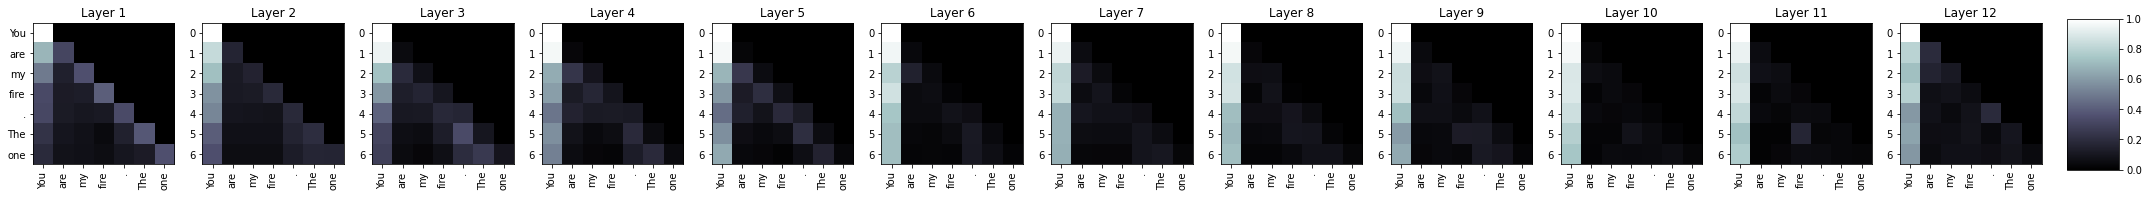

6398it [04:53, 22.36it/s]

  Step 6,400  of  9,953. Loss: 3.8945603370666504.   Elapsed: 0:04:54.
>Sidney and her boyfriend, Josh, had taken a couple of flights to England this week for a little-known concert in Manchester. She's done some shopping in Manchester, but couldn't seem to find his favourite hotel. There's a pub in Manchester called The Oakenfold, and she found a way back to the real place.

As it turns out, she's spent the past couple of weeks searching for a hotel she can get herself into. As she goes in for a last minute night, it's not quite the hotel. It's the one she has to hide in a corner.

In the early hours, they got into a fight. They've been on the go for so long it's almost like you're going into a movie. She says, "It's been so long that I don't even want to sleep in a hotel at all."

But she's determined to find the sweet spot if she
 who -> 0.7136647701263428
 that -> 0.11128803342580795
 I -> 0.08779929578304291
 you -> 0.046990204602479935
 with -> 0.01980013959109783
 thing -> 0.004

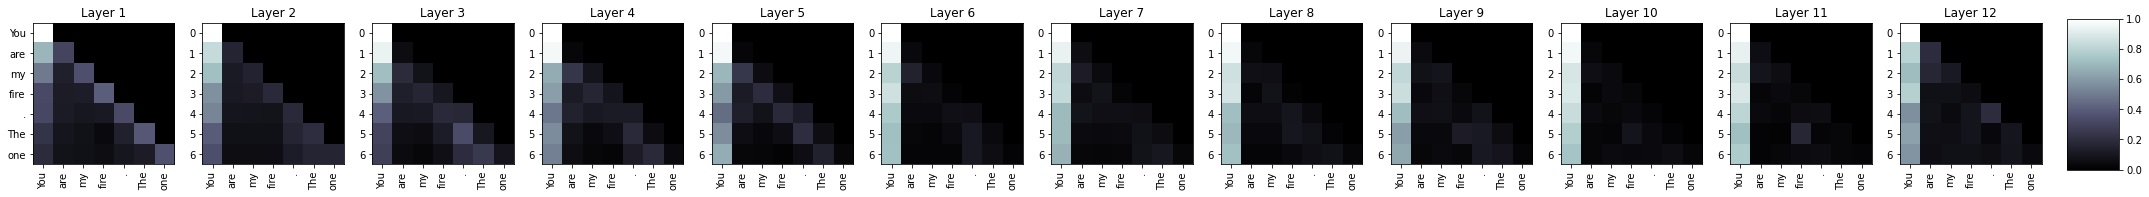

9600it [07:27, 18.42it/s]

  Step 9,600  of  9,953. Loss: 2.4706356525421143.   Elapsed: 0:07:28.
> round the world. I knew it, for now I think it's broken. I saw it, but it's broken. And now I still doubt it. It's broken. I see it, but it's broken. And now I still doubt it. It's broken. I see it, but it's broken. And now I still doubt it. It's broken. [8:40:54 PM] Daphne: I know, but it's broken. I saw it. But it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it
 who -> 0.6134127974510193
 that -> 0.15923276543617249
 I -> 0.1300155520439148
 you -> 0.05735042691230774
 with -> 0.020901139825582504
 thing -> 0.004289435222744942
 to -> 0.004204801749438047
 in -> 0.0038783762138336897
 of -> 0.003534805728122592
 and -> 0.0031799618154764175


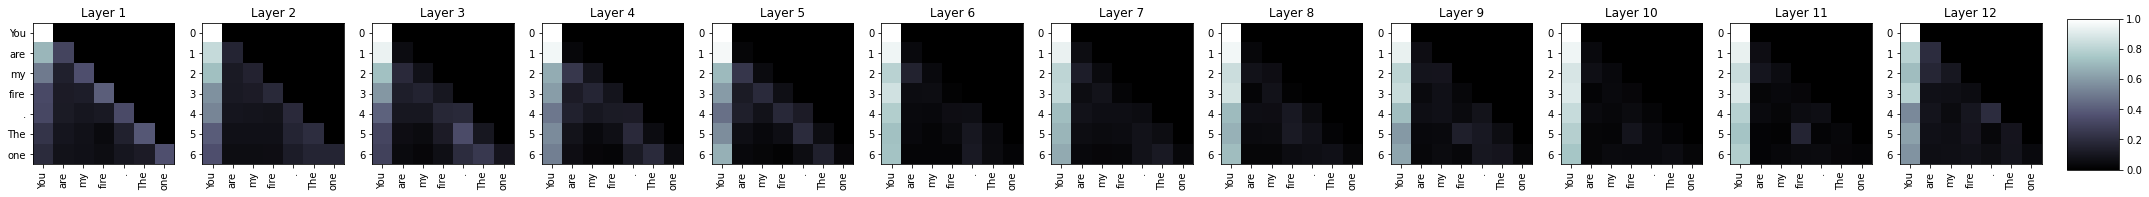

9953it [07:47, 21.28it/s]



  Average training loss: 2.76
  Training epoch took: 0:07:48

Running Validation...
  Validation Loss: 2.58
  Validation took: 0:00:09


2it [00:00, 17.58it/s]


======== Epoch 2 / 21 ========
Training...


1018it [00:48, 20.03it/s]

In [ ]:
import regex as re

# Wandb manage model weights statistics 
wandb.watch(model)

total_t0 = time.time()
# training_stats = []
# min_val_loss = float('inf')

for epoch_i in range(current_epoch+1, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i, epochs))
    print('Training...')
    
    t0 = time.time()
    model.train()
    total_train_loss = 0
    loss = 0
    for step, batch in tqdm(enumerate(train_dataloader)):
        
        b_input_ids = batch[0].to(device).unsqueeze(0) # Need to have 2 sizes
        
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids,
                        lm_labels=b_input_ids,) 
#                           attention_mask=b_masks,)\
#         print(outputs)
#         raise
        loss = outputs[0] 
        batch_loss = loss.item()
        total_train_loss += batch_loss
        loss /= gradient_acc_steps 
        
        # Attention table
        
        # Get sample every x batches.
        if (step/gradient_acc_steps) % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Step {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            
            # Generate a sample sequence
            out = sample_sequence(
                model=model, length=200,
                context=random.randint(1,30000),
                batch_size=1,
                temperature=0.95, 
                top_k=50, device=device
            )
            out = out[:, len(context_tokens):].tolist()
            text = enc.decode(out[0])
            print(f">{text}")

            # Show attention table
            context_text = "You are my fire. The one"
            display_attn_and_confidence(model, context_text)
            
            model.train()
        
        # Update
        loss.backward()
        
        if (step+1) % gradient_acc_steps == 0 or (step + 1 == len(train_dataloader)):            
            optimizer.step()
            scheduler.step()
            wandb.log(
                {
                    "epoch": epoch_i,
                    'batch_loss': batch_loss
                }
            )
            # wandb log attention table
#             wandb.join()
        
    # Report training
    avg_train_loss = total_train_loss / len(train_dataloader)       
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device).unsqueeze(0)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)  
        
        with torch.no_grad():        
            outputs  = model(b_input_ids, 
                             lm_labels=b_input_ids,) 
#                            token_type_ids=None, 
#                              attention_mask = b_masks,          
            loss = outputs[0]  
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    # Report validation
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    if min_val_loss > avg_val_loss:
        min_val_loss = avg_val_loss
    validation_time = format_time(time.time() - t0)    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    if save_model_on_epoch:
        # Save training stats
        with open(os.path.join(output_dir, "stats.json"), 'w') as f:
            json.dump(training_stats, f)
        # Save two files: current best model and current epoch model
        if avg_val_loss < min_val_loss:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-best.pt"),
            )
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"{output_prefix}-{epoch_i}.pt"),
        )
        if epoch_i > 1:
            # Remove previous checkpoint
            os.remove(os.path.join(output_dir, f"{output_prefix}-{epoch_i-1}.pt"))

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
type(model) == GPT2LMHeadModel

In [ ]:
# Need to generate lyrics for test set, get loss, evaluate on persplexity, bleu and rougev 
# Want to see model's confidence knowing context as well -> attention 

In [ ]:
# Need to check if exists directory, if no, try to create
# Try save a dummy model and delete it
# These checks are done at the start of notebook
# Resume: Check if the directory has a checkpoint

In [ ]:
# config = GPT2Config()
# model = GPT2LMHeadModel(config)
model, current_epoch, min_val_loss, training_stats = load_checkpoint(model, output_dir, output_prefix)

In [ ]:
def print_nested_tuple(x):
    if type(x) == tuple:
        print(len(x))
        for y in x:
            print_nested_tuple(y)
    else:
        print(x.shape)

In [ ]:
# ========================================
#               Test
# ========================================

length = 20
temperature=0.7
top_k=40
model.cuda()

print("")
print("Running Test...")

t0 = time.time()
model.eval()
total_eval_loss = 0
contexts = []
true_lyrics = []
generated_lyrics = []
# Evaluate data for one epoch
for i, batch in tqdm(enumerate(test_dataloader)):
#     print(batch.shape)
    
#     if i % 1 == 0:
#         print(f"{i}/{len(test_dataloader)}")
    
    b_input_ids = batch.to(device).view(batch_size, -1)
#     print(b_input_ids.shape)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)  

    context = b_input_ids[:,:-length].view(batch_size, -1)
    prev = context
    output = context
    past = None
    with torch.no_grad():   
        # Generate text
        for i in range(length):
            try:
                logits, past = model(prev, 
                                 past=past)
            except:
                print(b_input_ids.shape)
                raise
#             print(logits.shape)
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, k=top_k)
            log_probs = F.softmax(logits, dim=-1)
#             if sample:
            prev = torch.multinomial(log_probs, num_samples=1)
#             else:
#                 _, prev = torch.topk(log_probs, k=1, dim=-1)
            output = torch.cat((output, prev), dim=1)
          
        # Find loss
        loss, _, _  = model(b_input_ids, 
                         lm_labels=b_input_ids,)
    
    batch_loss = loss.item()
    total_eval_loss += batch_loss
    
    output = output[:, len(context):].tolist()
    text = enc.decode(output[0])
#     print(f"{context}\n->{text}")
    
    contexts.append(enc.decode(list(context[0].cpu().numpy())))
    true_lyrics.append(enc.decode(list(batch.view(-1).cpu().numpy())[-length:]))
    generated_lyrics.append(text)
    
#     print(f"Outputs have {len(outputs)} items:\noutputs[0]={outputs[0]}\noutputs[1]={outputs[1].shape}\noutputs[2]={[x.shape for x in outputs[2]]}")
#     if i >= 3:
#         break
    
# Report validation
avg_test_loss = total_eval_loss / len(test_dataloader)
test_time = format_time(time.time() - t0)    
print("  Test Loss: {0:.2f}".format(avg_test_loss)) #2.25
print("  Test took: {:}".format(test_time))
len(contexts), len(true_lyrics), len(generated_lyrics)

In [ ]:
contexts[7]+"|||"+true_lyrics[7], contexts[7]+"|||"+generated_lyrics[7]

In [ ]:
# #Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(true_lyrics)):
    to_remove = generated_lyrics[i].split('.')[-1]
    final.append(generated_lyrics[i].replace(to_remove,''))

# test_set['Generated_lyrics'] = final
# test_set.head()

In [ ]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(true_lyrics)):
    reference = [true_lyrics[i]]
    candidate = final[i]
    scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

In [ ]:
#Rouge score
from rouge import Rouge
rouge=Rouge()

rouge.get_scores(final, true_lyrics, avg=True, ignore_empty=True)

In [ ]:
# from torch.utils.data import DataLoader
# from torch.utils.data import RandomSampler, SequentialSampler

# # Create the DataLoaders for our datasets.
# # We'll take training samples in random order. 
# train_dataloader = DataLoader(
#             train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
#             batch_size = batch_size # Trains with this batch size.
#         )
# # For validation and test the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )
# test_dataloader = DataLoader(
#             test_dataset, # The validation samples.
#             sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

In [ ]:
# Each entry of the matrix is a row in attention table (for wandb logging)
        # Log wandb
#         columns=["s_ind", "t_ind", "s_word", "t_word", "attn"]
#         attn_table = wandb.Table(columns=columns)
#         temp = context_text.split(" ")
#         for s_ind in range(seq_len):
#                 attn_table.add_data(s_ind, t_ind, temp[s_ind], temp[t_ind], attn_maps[row][column][0][s_ind][t_ind])
#         wandb.log({"attn_table": attn_table})